<a href="https://colab.research.google.com/github/Gutzu-Encoder/Chest--Xray-penumonia-/blob/main/Chest_penumonia_xray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Dataset from kaggle
ถ้าเราจะใช้ dataset จาก kaggle ให้ดีจะต้อง set up something ก่อน
- อย่างเเรก upload file kaggle.json เข้า workspace ก่อน
วิธีคือสมัครเเอ็ค kaggle เเละ verify ตัวเอง => "Create New API Token" => มันจะโหลดไฟลืชื่อ kaggle.json ให้ รัน from google.colab import files
files.upload() เเล้วเอา kaggle.json เเละเอาไฟลื kaggle.json เข้่า

- ขั้น 2 ก็เอา data เข้าก็ตามนั้นเเหละ
- ข้ัน 3 ก้โหลดเเละ unzip

In [12]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"krityotch","key":"1a38456f1b465213b88261ac8eeafb66"}'}

In [13]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [14]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip -d data


Streaming output truncated to the last 5000 lines.
  inflating: data/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: data/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: data/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: data/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: data/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: data/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: data/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: data/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: data/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: data/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: data/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: data/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: data/chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: data/chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: data/chest_xray/train/NORMAL/IM-0446-0001.j

#Dataset analysis
ก่อนที่เราจะเริ่มทำการอะไร เราต้องเช้คก่อนว่า dataset เราเป็นยังไงเเบบ input channel ยังไง มีตัวไฟลื train test อะไร location มันตรงไหนบลาๆๆ จะได้หยิบมันถูกหรือทำ transfer learning ก็จะได้ทำได้ tune ตรงกัน

In [16]:
import os
import pandas as pd

base_dir = '/content/data/chest_xray'
splits = ['train', 'test', 'val']
labels = ['NORMAL', 'PNEUMONIA']

data = []

for split in splits:
    for label in labels:
        folder_path = os.path.join(base_dir, split, label)
        if os.path.exists(folder_path):
            num_files = len(os.listdir(folder_path))
        else:
            num_files = 0
        data.append([split, label, num_files])

df = pd.DataFrame(data, columns=['Split', 'Label', 'Number of Images'])
print(df)



   Split      Label  Number of Images
0  train     NORMAL              1341
1  train  PNEUMONIA              3875
2   test     NORMAL               234
3   test  PNEUMONIA               390
4    val     NORMAL                 8
5    val  PNEUMONIA                 8


ก้จะเห็นข้อมูลต่างๆว่ามีเท่าไหร่ ไอชื่อไฟลืมันชื่ออะไร ชื่อ train test val ชื่อ PNEUMONIA บลาๆ จะได้ตอนพิมพ์เรียกใช้ออกมาจะได้ทำถูก

ต่อมาเราจะมาลอง check รุปกันว่าเป็นไง

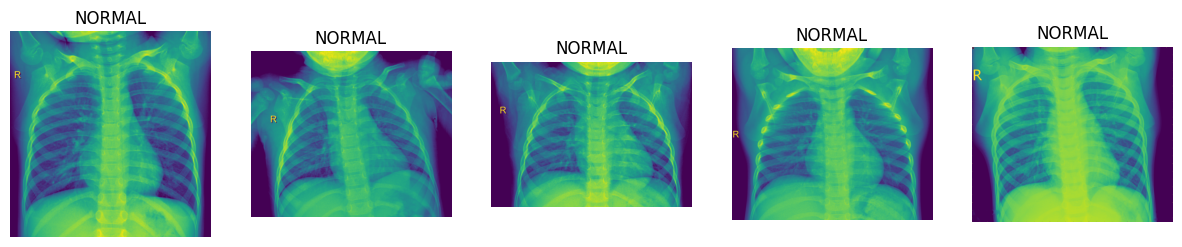

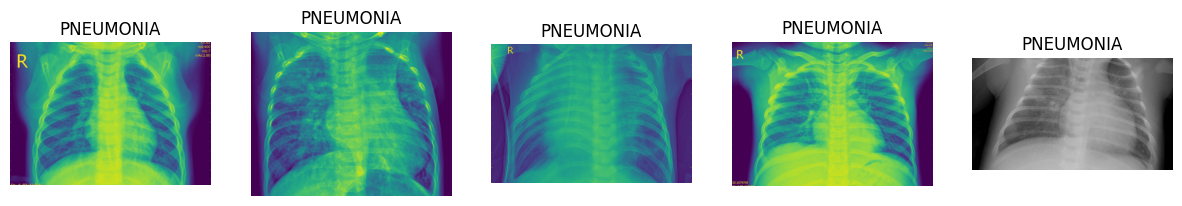

In [18]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

def show_images(split='train', label='PNEUMONIA', n=5):  #จากการ check data ทำให้เรารุ้ชื่อไฟล์ เราก็เรียกใช้ออกมาได้เลย
    folder = f"/content/data/chest_xray/{split}/{label}"
    images = os.listdir(folder)
    samples = random.sample(images, n)

    plt.figure(figsize=(15, 5))
    for i in range(n):
        img = mpimg.imread(os.path.join(folder, samples[i]))
        plt.subplot(1, n, i + 1)
        plt.imshow(img) ###
        plt.title(f"{label}")
        plt.axis('off')
    plt.show()


show_images('train', 'NORMAL')
show_images('train', 'PNEUMONIA')


จะเห็นว่ามันเป็นภาพสี ถ้าอยากได้เป็นขาวดำต้องปรับตรง plt.imshow(img)

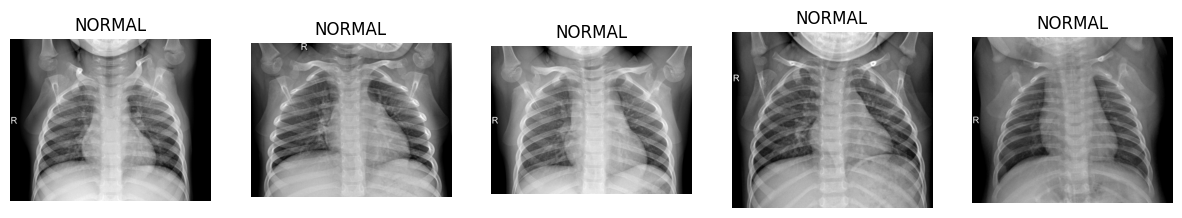

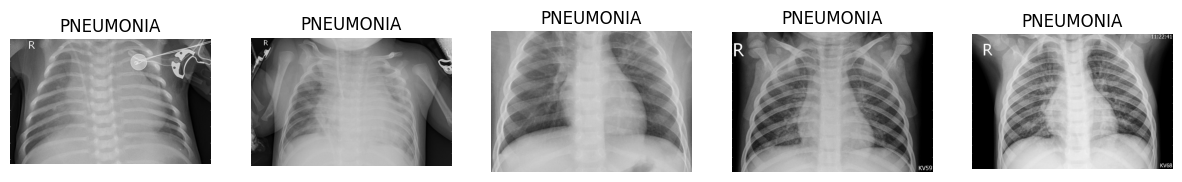

In [19]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

def show_images(split='train', label='PNEUMONIA', n=5):
    folder = f"/content/data/chest_xray/{split}/{label}"
    images = os.listdir(folder)
    samples = random.sample(images, n)

    plt.figure(figsize=(15, 5))
    for i in range(n):
        img = mpimg.imread(os.path.join(folder, samples[i]))
        plt.subplot(1, n, i + 1)
        plt.imshow(img, cmap = 'gray') ###
        plt.title(f"{label}")
        plt.axis('off')
    plt.show()


show_images('train', 'NORMAL')
show_images('train', 'PNEUMONIA')

ต่อมาจะทำการ check image size and dimension

In [20]:
from PIL import Image
import os

folder = '/content/data/chest_xray/train/PNEUMONIA'
sizes = []

for fname in os.listdir(folder)[:100]:
    path = os.path.join(folder, fname)
    with Image.open(path) as img:
        sizes.append(img.size)

import pandas as pd
size_counts = pd.Series(sizes).value_counts()
print(size_counts.head(10))


(1716, 1222)    1
(976, 832)      1
(1208, 688)     1
(1072, 672)     1
(1072, 648)     1
(840, 544)      1
(1064, 616)     1
(1032, 696)     1
(1288, 744)     1
(1128, 752)     1
Name: count, dtype: int64


สิ่งที่เห็นคือว่า (1716, 1222)  คือเเสดง  image size เป็น width, height เเล้วจะพบว่ามันไม่เท่ากันเลย => ขนาดรูปมันไม่ consistent!!! => ต้องไป transform
ส่วน 1 คือไม่มีรุปซ้ำ


In [21]:
import matplotlib.image as mpimg
import numpy as np
import os
import random

# Pick a random NORMAL image
normal_path = os.path.join(base_dir, 'train', 'NORMAL')
pneumonia_path = os.path.join(base_dir, 'train', 'PNEUMONIA')

normal_img_path = os.path.join(normal_path, random.choice(os.listdir(normal_path)))
pneumonia_img_path = os.path.join(pneumonia_path, random.choice(os.listdir(pneumonia_path)))

# Load and print pixel info
def print_pixel_info(img_path):
    img = mpimg.imread(img_path)
    print(f"Image: {os.path.basename(img_path)}")
    print(f"- Shape: {img.shape}")
    print(f"- Dtype: {img.dtype}")
    print(f"- Min: {np.min(img)}, Max: {np.max(img)}")
    print()

print_pixel_info(normal_img_path)
print_pixel_info(pneumonia_img_path)


Image: IM-0736-0001.jpeg
- Shape: (1005, 1430)
- Dtype: uint8
- Min: 0, Max: 255

Image: person321_bacteria_1484.jpeg
- Shape: (728, 1104)
- Dtype: uint8
- Min: 0, Max: 255



ก่อนทีจะดูตัวโค้ดข้างบนเราต้องเข้าใจก่อนว่า "รูป" ในทางไพธอนจะมี 3 องค์หลักๆ
- Shape: บอก dimension ถ้า RGB ก็ 3 ถ้า BWก้ 1
- dtype: บอกว่า ค่าใน pixel เป็น float หรือ int
- min/ Max: บอก pixel value range => ก็คือ intensity อ่ะ
เอาง่ายๆนะ ภ่าพเดียวกัน 2 ภาพ อันนึงปรับสว่างสุด อันนึงปรับมืดสุดอย่าว่าเเต่คอมเลย คนก้ดุไม่ออก เราเลยต้องเช้คเพื่อที่จะ normalize ตรงนี้

min max ก็คือว่าไอภาพๆนี้ หรือถ้า geek ฟิสิกสืก้คือไอระบบนี่มันอยู่ในกฏเดียวกันมั้ย ถ้าภาพ 1 ได้ตั้งเเต่ 0-1 เเต่ ภาพ 2 ได้ 0-255 อันนี้ไม่ได้ละวัดกันยาก เลยต้องเช้คเพื่อเอามาปรับ ( เเต่ทำงานจริงเขาก้ปรับๆไปเเบบไม่ค่อนเช็คกันอยู่เเล้วเเต่อันนี้เอาให้ดูเฉยๆ)

ต่อมาเราจะเช็ค image channel => RGB/ Black- white? เพราะอย่าง resnet ต้องการ input เป็น 3 คือ RGB เเต่อันนี้เรามัน grayscale ไง มันจะรันไม่ได้ เลยต้องปรับ

In [22]:
from PIL import Image
import os
import random

img_path = os.path.join(base_dir, 'train', 'NORMAL', random.choice(os.listdir(os.path.join(base_dir, 'train', 'NORMAL'))))

with Image.open(img_path) as img:
    print(f"Mode: {img.mode}")
    print(f"Size: {img.size}")


Mode: L
Size: (1700, 1302)


Mode: L ก็คือว่ามันเป็น b/W => ปรับเป็น RGB ( unless เราใช้อะไรทีมัน ok กับการที่เป็น B?W อยู่เเล้ว
-จะปรับตอน train ก้ได้หรือก่อนก็ได้
หลักๆคือเราสร้าง parameter เก็บตัวไฟล์ เเล้วเอา parameter นั้นไป convert เป็น RGB เเต่ตอนนี้ยังไม่ทำ เดี๋ยวค่อยทำ( กลัวลืมว่าตั้งชื่อ parameter ว่าไร)

** ก่อนหน้านี้ไม่ใช่ data preprocess เป้นเเค่การเช้ค + ตรวจดุ data หลังจากนี้จะเป็นการ preprocess

# Data Preprocesing

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torchvision
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [32]:
from torchvision import transforms

def to_rgb(img):
    return img.convert("RGB")

transform = transforms.Compose([
    transforms.Lambda(to_rgb),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

data_dir = "/content/data/chest_xray"

train_dataset = datasets.ImageFolder(root=f"{data_dir}/train", transform=transform)
val_dataset   = datasets.ImageFolder(root=f"{data_dir}/val", transform=transform)
test_dataset  = datasets.ImageFolder(root=f"{data_dir}/test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32)
test_loader  = DataLoader(test_dataset, batch_size=32)


In [37]:
from torchvision import datasets, models, transforms
class TransferNet(nn.Module):
    def __init__(self, backbone, num_classes):
        super(TransferNet, self).__init__()
        self.model = backbone

        # Freeze backbone
        for param in self.model.parameters():
            param.requires_grad = False

        # Replace final layer
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.model(x)
backbone = torchvision.models.resnet18(pretrained=True)
net = TransferNet(backbone=backbone, num_classes=2).to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [38]:
from torch.optim import lr_scheduler, Adam
criterion = nn.CrossEntropyLoss()
optimizer = Adam(net.parameters(), lr=0.0001)

In [39]:
for epoch in range(3):
    net.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = net(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    print(f"Epoch {epoch+1}: Loss = {running_loss:.4f}, Accuracy = {acc:.4f}")


Epoch 1: Loss = 73.6037, Accuracy = 0.7812
Epoch 2: Loss = 49.7520, Accuracy = 0.8838
Epoch 3: Loss = 40.6129, Accuracy = 0.9036


In [40]:
def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():  # no gradients needed
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")
    return accuracy

# Run evaluation after training
evaluate(net, test_loader)

Test Accuracy: 0.7788


0.7788461538461539